In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import load_model
from keras.utils import plot_model

from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, GRU
from tensorflow.keras.preprocessing import sequence

### Read data ###

In [3]:
df = pd.read_csv('./BTC-USD.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
1,2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076
2,2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
3,2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788
4,2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909 entries, 0 to 1908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1909 non-null   object 
 1   Open       1909 non-null   float64
 2   High       1909 non-null   float64
 3   Low        1909 non-null   float64
 4   Close      1909 non-null   float64
 5   Adj Close  1909 non-null   float64
 6   Volume     1909 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 104.5+ KB


In [74]:
df.shape

(1909, 7)

### Descriptive statistc ###

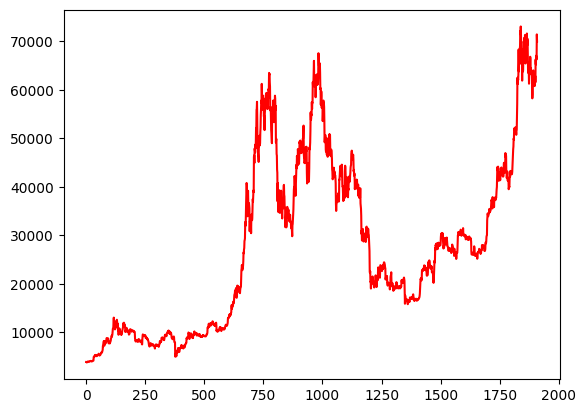

In [8]:
plt.figure()
plt.plot(df["Close"], color='red')
plt.show()

<Axes: >

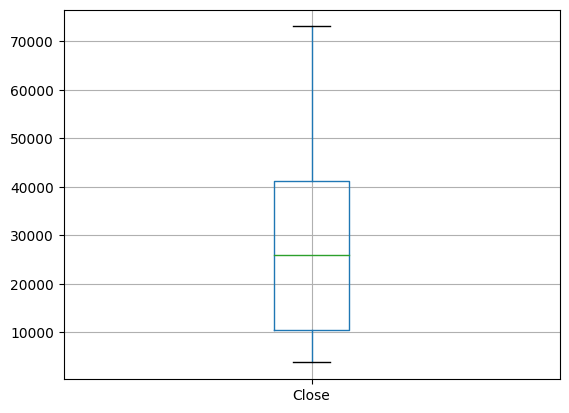

In [12]:
df.boxplot(column=['Close'])

In [18]:
column='Close'
summary = {
    'mean': df[column].mean(),
    'mode': df[column].mode()[0], 
    'std': df[column].std(),
    'var': df[column].var(),
    'kurtosis': kurtosis(df[column]),
    'skewness': skew(df[column]),
    'range': df[column].max() - df[column].min(),
    'min': df[column].min(),
    'max': df[column].max(),
    'sum': df[column].sum(),
    'count': df[column].count()
}

print(f"Summary statistics for column {column}:")
for stat, value in summary.items():
    print(f"{stat}: {value}")


Summary statistics for column Close:
mean: 27700.52769653222
mode: 3761.557129
std: 17708.57514402739
var: 313593633.6316647
kurtosis: -0.6948182249917778
skewness: 0.5713889457991368
range: 69321.942871
min: 3761.557129
max: 73083.5
sum: 52880307.37268001
count: 1909


### Preprocess data ###

In [75]:
df['Date'] = pd.to_datetime(df['Date'])
df.reset_index(drop=True)
df.set_index('Date', inplace=True)


In [76]:

df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [77]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
Date,,,,,,,,,
2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975,2019,3,1
2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076,2019,3,2
2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152,2019,3,3
2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788,2019,3,4
2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415,2019,3,5


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1909 entries, 2019-03-01 to 2024-05-21
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1909 non-null   float64
 1   High       1909 non-null   float64
 2   Low        1909 non-null   float64
 3   Close      1909 non-null   float64
 4   Adj Close  1909 non-null   float64
 5   Volume     1909 non-null   int64  
 6   Year       1909 non-null   int64  
 7   Month      1909 non-null   int64  
 8   Day        1909 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 149.1 KB


In [79]:
df.shape

(1909, 9)

### Parameter

In [80]:
window_size = 10
feature_dim = 5
test_size=0.2

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

### Split data

In [81]:
split_index = int(len(df)*(1-test_size))
df_train = df.iloc[:split_index,:]
df_test = df.iloc[split_index:,:]

In [82]:
print('df_train.shape: ',df_train.shape)
print('df_trest.shape: ',df_test.shape)

df_train.shape:  (1527, 9)
df_trest.shape:  (382, 9)


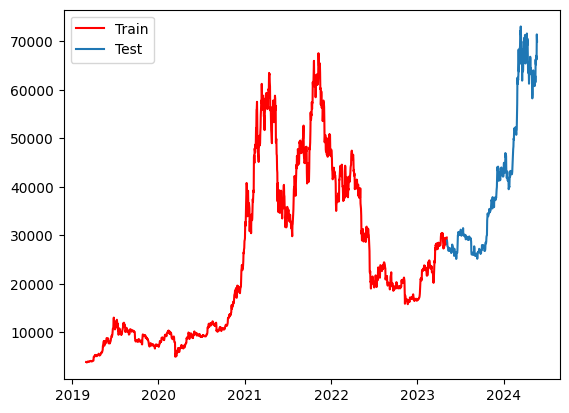

In [85]:
plt.figure()
plt.plot(pd.DataFrame(df_train).index.to_list(), pd.DataFrame(df_train['Close']), color='red', label='Train')
plt.plot(pd.DataFrame(df_test).index.to_list(),pd.DataFrame(df_test['Close']), label ='Test')
plt.legend()
plt.show()

In [86]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=df_test.columns)

In [11]:
def train_test_split(X, y,test_size, window_size=10 ):
    split_index = int(len(X) * (1 - test_size))
    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]
    if window_size is not None:
        X_train = np.array([X_train[i:i+window_size] for i in range(len(X_train)-window_size)])
        y_train = y_train[window_size:]
        X_test = np.array([X_test[i:i+window_size] for i in range(len(X_test)-window_size)])
        y_test = y_test[window_size:]
    return X_train, y_train, X_test, y_test